In [1]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

import json
import numpy as np
import pandas as pd
from datetime import date,datetime,timedelta

from django_connect import connect
connect()

import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from db.models import *

def get_ecephys_cache():
    manifest = 'C:/Users/yoni.browning/Documents/DataJoint/AllenData/manifest.json'
    return EcephysProjectCache(manifest=manifest)




In [2]:
import prefect
from prefect import task, Flow
from django_pandas.io import read_frame


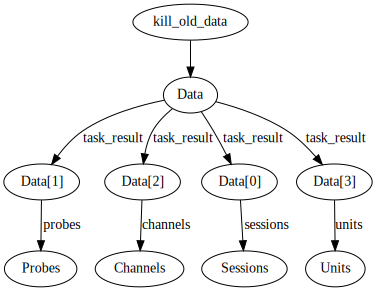

In [3]:
# Ingest general data
from prefect.triggers import all_successful, all_failed,any_successful

@task
def kill_old_data():
    Genotype.objects.all().delete()
    Mouse.objects.all().delete()
    Structure.objects.all().delete()
    SessionType.objects.all().delete()
    Session.objects.all().delete()
    ProbePhase.objects.all().delete()
    SessionProbe.objects.all().delete()
    Channel.objects.all().delete()
    Unit.objects.all().delete()

@task(name = "Data",nout = 4,trigger = all_successful)
def extract_data():
    cache = get_ecephys_cache()

    sessions = cache.get_session_table(suppress=[])
    probes = cache.get_probes()
    channels = cache.get_channels()
    units = cache.get_units(filter_by_validity=False,
                            amplitude_cutoff_maximum = np.inf,
                            presence_ratio_minimum = -np.inf,
                            isi_violations_maximum = np.inf)
    return (sessions,probes,channels,units)

        
@task(name = "Sessions")
def make_sessions(sessions):
    # preprocess sessions
    sessions['acquisition_datetime'] = sessions['date_of_acquisition'].map(lambda v: datetime.strptime(v, "%Y-%m-%dT%H:%M:%S%z"))
    sessions['publication_datetime'] = sessions['published_at'].map(lambda v: datetime.strptime(v, "%Y-%m-%dT%H:%M:%S%z"))
    sessions.drop(columns=['date_of_acquisition',
                           'published_at'],
                  inplace=True)
    # Genotypes
    unique_genotypes = sessions['full_genotype'].unique()
    genotypes = pd.DataFrame(data={'name': unique_genotypes}).reset_index().rename(columns={'index':'id'})
    Genotype.objects.bulk_create([ Genotype(**v) for v in genotypes.to_dict(orient='records') ])

    # Mice
    mice = sessions[['acquisition_datetime', 'age_in_days', 'specimen_id','sex','full_genotype']]
    mice['date_of_birth'] = mice.apply(lambda r: r['acquisition_datetime'].date() - timedelta(r['age_in_days']), axis=1)
    mice = mice[['specimen_id','sex','date_of_birth','full_genotype']].set_index('specimen_id')
    mice = mice.reset_index().merge(genotypes, left_on='full_genotype', right_on='name').rename(columns={'specimen_id':'id', 'id':'genotype_id'}).drop(columns=['full_genotype','name'])
    Mouse.objects.bulk_create([ Mouse(**v) for v in mice.to_dict(orient='records') ])
    
    # Structures
    with open('./structures.json','r') as f:
        structures = json.load(f)
        structures = pd.DataFrame.from_records(structures['msg'])
    structures = structures[['acronym', 'name', 'color_hex_triplet', 'id', 'structure_id_path', 'hemisphere_id', 'graph_order', 'parent_structure_id']]
    structures.replace(np.nan, None, inplace=True)
    structures = structures.rename(columns={'acronym':'abbreviation'})
    Structure.objects.bulk_create([ Structure(**v) for v in structures.to_dict(orient='records') ])

    # Session Types
    session_types = pd.DataFrame(data={'name': sessions['session_type'].unique()}).reset_index().rename(columns={'index':'id'})
    SessionType.objects.bulk_create([ SessionType(**v) for v in session_types.to_dict(orient='records') ])

    # Finish sessions
    sessions = sessions[['specimen_id','session_type','acquisition_datetime','publication_datetime']]
    sessions = sessions.reset_index().merge(session_types, left_on='session_type', right_on='name')
    sessions = sessions.rename(columns={'id_x':'id', 'id_y':'session_type_id'}).drop(columns=['session_type','name']) 
    Session.objects.bulk_create([ Session(**v) for v in sessions.to_dict(orient='records') ])

@task(name = "Probes")
def make_probes(probes):
     # ingest probe phases
    probe_phases = pd.DataFrame(data={'name': probes['phase'].unique()}).reset_index().rename(columns={'index':'id'})

    ProbePhase.objects.all().delete()
    ProbePhase.objects.bulk_create([ ProbePhase(**v) for v in probe_phases.to_dict(orient='records') ])

    # ingest probes
    probes = probes[['ecephys_session_id','phase','lfp_sampling_rate','sampling_rate','name']].rename(columns={'name':'probe_name'}).reset_index()
    probes = probes.merge(probe_phases, left_on='phase', right_on='name')
    probes = probes.rename(columns={'id_x':'id','id_y':'probe_phase_id','ecephys_session_id':'session_id'}).drop(columns=['phase','name'])

    SessionProbe.objects.bulk_create([ SessionProbe(**v) for v in probes.to_dict(orient='records') ])

@task(name = "Channels")
def make_channels(channels):
    channels = channels.reset_index().rename(columns={'ecephys_probe_id':'session_probe_id', 'ecephys_structure_id':'structure_id'})
    channels = channels.drop(columns=['unit_count','has_lfp_data','phase','ecephys_structure_acronym','ecephys_session_id'])
    channels['structure_id'].replace(np.nan, None, inplace=True)

    Channel.objects.bulk_create([ Channel(**v) for v in channels.to_dict(orient='records') ])

    
    
@task(name = "Units")
def make_units(units):
    units = units.reset_index().rename(columns={'ecephys_channel_id':'channel_id','waveform_PT_ratio':'waveform_pt_ratio','L_ratio':'l_ratio'})
    units = units[['amplitude_cutoff', 'cumulative_drift', 'd_prime',
                   'firing_rate', 'isi_violations', 'isolation_distance',
                   'l_ratio', 'max_drift', 'nn_hit_rate', 'nn_miss_rate',
                   'presence_ratio', 'silhouette_score', 'snr', 'quality',
                   'waveform_pt_ratio', 'waveform_amplitude', 'waveform_duration',
                   'waveform_halfwidth', 'waveform_spread', 'waveform_velocity_above',
                   'waveform_velocity_below', 'waveform_recovery_slope',
                   'waveform_repolarization_slope', 'id', 'channel_id']]
    Unit.objects.bulk_create([ Unit(**v) for v in units.to_dict(orient='records') ])


with Flow("Populate") as flow:
    (sessions,probes,channels,units) = extract_data(upstream_tasks = [kill_old_data])
    make_sessions(sessions)
    make_probes(probes)
    make_channels(channels)
    make_units(units)
    
flow.visualize()

In [ ]:
flow.run()

In [4]:
import numbers
import ast

def clean_string(v):
    if v is None:
        return None

    if isinstance(v, numbers.Number):
        return v

    v = ast.literal_eval(v.strip())

    if isinstance(v, list):
        return v[0]
    return v

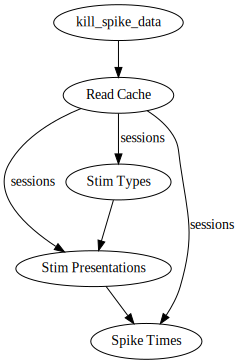

In [8]:
# Ingest Spike times and stimulus table from the data we have on hand
from typing import Tuple

@task
def kill_spike_data():
    StimulusType.objects.all().delete()
    SpikeTime.objects.all().delete()
    StimulusPresentation.objects.all().delete()

@task(name = "Read Cache")
def read_cache():
    cache = get_ecephys_cache()
    this_sessions = cache.get_session_table(suppress=[]).head(3)
    return [ cache.get_session_data(idx) for idx, row in this_sessions.iterrows() ]

@task(name = "Stim Types")
def ingest_stimulus_types(sessions):
    pass
    # This takes a long time, so I am skipping but leaving the code.
    stim_table = pd.concat([s.stimulus_presentations for s in sessions])
    
    # stimulus types
    stim_types = pd.DataFrame(data={'name': stim_table['stimulus_name'].unique()}).reset_index().rename(columns={'index':'id'})
    StimulusType.objects.bulk_create([StimulusType(**v) for v in stim_types.to_dict(orient='records')])


@task(name = "Stim Presentations")
def ingest_stimulus_presentations(sessions):
    # stimulus types
    stim_types = read_frame(StimulusType.objects.all())

    for session in sessions:
        # stimulus presentations
        stim_table = session.stimulus_presentations
        stim_table = stim_table.replace({'null':None})

        for k in ['phase','size','spatial_frequency']:
            stim_table[k] = stim_table[k].apply(clean_string)

        stim_table = stim_table.reset_index()
        stim_table = stim_table.merge(stim_types.reset_index(), left_on='stimulus_name', right_on='name', how='left')
        stim_table = stim_table.rename(columns={'id':'stimulus_type_id'}).drop(columns=['stimulus_name','name','index'])
        stim_table['session_id'] = pd.Series([session.ecephys_session_id]*len(stim_table))
        stim_table = stim_table.fillna(np.nan).replace({np.nan:None})

        StimulusPresentation.objects.bulk_create([ StimulusPresentation(**v) for v in stim_table.to_dict(orient='records')])

@task(name = "Spike Times")
def ingest_spike_times(sessions):
    for session in sessions:
        # spike times
        for unit_id, unit_spike_times in session.spike_times.items():
            st = UnitSpikeTimes(unit_id=unit_id, spike_times=list(unit_spike_times))
            st.save()
            print(unit_id)
            

with Flow("Stimulus and Spikes") as flow2:
    sessions = read_cache(upstream_tasks = [kill_spike_data])
    # This line is made of nested functions just so everything runs in the order I want
    r0 = ingest_stimulus_types(sessions)
    r1 = ingest_stimulus_presentations(sessions,upstream_tasks = [r0])
    r2 = ingest_spike_times(sessions,upstream_tasks=[r1])

flow2.visualize()

In [7]:
flow2.run()